In [2]:
from keras.datasets import imdb
from keras import backend as K
from keras.layers import Layer
from keras.models import Sequential, Model
from keras.layers import LSTM, GRU, Dense, Embedding, Concatenate
from keras import optimizers
import pandas as pd
import re
import matplotlib.pyplot as plt

In [3]:
MAX_LEN = 100
BATCH_SIZE = 256
EMBEDDING_SIZE = 32
MIN_FREQ = 3
PAD_TOKEN = "*$*PAD*$*"
UNK_TOKEN = "*$*UNK*$*"

VAL_DICT = {'pos': 1,
            'neg': 0}

In [6]:


def clean_en(text, lower=True):
    """
    Tokenization/string cleaning.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    :param text: The string to be cleaned
    :param lower: If True text is converted to lower case
    :return: The clean string
    """
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", text)
    text = re.sub(r"\'s", " \'s", text)
    text = re.sub(r"\'ve", " \'ve", text)
    text = re.sub(r"n\'t", " n\'t", text)
    text = re.sub(r"\'re", " \'re", text)
    text = re.sub(r"\'d", " \'d", text)
    text = re.sub(r"\'ll", " \'ll", text)
    text = re.sub(r",", " , ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\(", " \( ", text)
    text = re.sub(r"\)", " \) ", text)
    text = re.sub(r"\?", " \? ", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text.strip().lower().encode('utf-8') if lower else text.strip().encode('utf-8')


def create_data(df, w2i, pad_tnk=PAD_TOKEN, unk_tkn=UNK_TOKEN,
                max_len=100):
    X = []
    y = []
    for i in range(len(df)):
        text = get_indexed_text(w2i, pad_text(df.iloc[i].tokenized_text, maxlen=max_len, pad_tkn=pad_tnk),
                                unk_token=unk_tkn)
        label = VAL_DICT[df.iloc[i].label]
        X.append(text)
        y.append(label)

    return X,y


def create_freq_vocabulary(tokenized_texts):
    """
    :param tokenized_texts: a list of lists of tokens
    :return: a word-to-integer dictionary with the value representing the frequency of the word in data
    """
    token_dict = {}
    for text in tokenized_texts:
        for token in text:
            try:
                token_dict[token] += 1
            except KeyError:
                token_dict[token] = 1
    return token_dict


def get_frequent_words(token_dict, min_freq):
    """
    :param token_dict: a word-to-integer dictionary with the value representing the frequency of the word in data
    :param min_freq: the minimum frequency
    :return: the list with tokens having frequency >= min_freq
    """
    return [x for x in token_dict if token_dict[x] >= min_freq]


def create_final_dictionary(tokenized_texts,
                            min_freq,
                            unk_token,
                            pad_token):
    voc = create_freq_vocabulary(tokenized_texts)
    print("tokens found in training data set:", len(voc))
    freq_words = get_frequent_words(voc, min_freq)
    print("tokens with frequency >= %d: %d" % (min_freq, len(freq_words)))
    words = [pad_token, unk_token] + freq_words
    return {w: i for i, w in enumerate(words)}


def get_indexed_value(w2i, word, unk_token):
    """
    return the index of a token in a word-to-index dictionary
    :param w2i: the word-to-index dictionary
    :param word: the token
    :param unk_token: to unknown token
    :return: an integer
    """
    try:
        return w2i[word]
    except KeyError:
        return w2i[unk_token]


def get_indexed_text(w2i, words, unk_token):
    """
    return the indices of the all the tokens in a list in a word-to-index dictionary
    :param w2i: the word-to-index dictionary
    :param words: a list of tokens
    :param unk_token: to unknown token
    :return: a list of integers
    """
    return [get_indexed_value(w2i, word, unk_token) for word in words]


def pad_text(tokenized_text, maxlen, pad_tkn):
    """
    fills a list of tokens with pad tokens if the length of the list is larger than maxlen
    or return the maxlen last tokens of the list
    :param tokenized_text: a list of tokens
    :param maxlen: the max length
    :param pad_tkn: the pad token
    :return: a list of tokens
    """
    if len(tokenized_text) < maxlen:
        return [pad_tkn] * (maxlen - len(tokenized_text)) + tokenized_text
    else:
        return tokenized_text[len(tokenized_text) - maxlen:]


def get_data_from_csv():
    df = pd.read_csv("../data/imdb.csv", encoding='iso-8859-1', error_bad_lines=False)
    df_train = df[df.type == 'train']
    df_test = df[df.type == 'test']
    return df_train, df_test

def generate_data(min_freq=MIN_FREQ,  max_len=MAX_LEN):
    """
    generates all necessary components for training and evaluation 
    :param min_freq: how many times a word must be found in data in order tο not being considered as unknown
    :param max_len: the padding size of text
    :return: a dict
    """

    train_df, test_df = get_data_from_csv()
    print('reviews for training:', len(train_df))
    print('reviews for testing:', len(test_df))
    train_df['tokenized_text'] = train_df['review'].map(lambda x: clean_en(x, True).split())
    test_df['tokenized_text'] = test_df['review'].map(lambda x: clean_en(x, True).split())
    tokenized_texts = list(train_df.tokenized_text) + list(test_df.tokenized_text)
    w2i = create_final_dictionary(tokenized_texts=tokenized_texts, min_freq=min_freq,
                                  unk_token=UNK_TOKEN, pad_token=PAD_TOKEN,)
    vocab_size = len(w2i)
    train_batches = create_data(train_df, w2i, max_len=max_len)
    test_batches = create_data(test_df, w2i, max_len=max_len)

    return {'train': train_batches, 'test': test_batches, 'vocab_size': vocab_size}




In [7]:
data = generate_data()

reviews for training: 25000
reviews for testing: 25000
tokens found in training data set: 112540
tokens with frequency >= 3: 53006


In [8]:
train_X, train_y = data['train']
test_X, test_y= data['test']
vocab_size = data['vocab_size']

In [9]:
def vanilla_model(unique_tokens, embedding_size, rnn_size, max_len):
    model = Sequential()
    model.add(Embedding(unique_tokens, embedding_size, input_length=max_len))
    model.add(LSTM(rnn_size))
    model.add(Dense(rnn_size, activation='relu'))
    model.add(Dense(1, activation=None))
    return model

In [10]:
model = vanilla_model(unique_tokens=vocab_size, embedding_size=EMBEDDING_SIZE, rnn_size=32, max_len=MAX_LEN)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           1696256   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,705,665
Trainable params: 1,705,665
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile('adam', 'binary_crossentropy', metrics=['acc'])

In [13]:
history = model.fit(epochs=10, x=train_X, y=train_y, validation_data=(test_X, test_y), batch_size=256, )

Instructions for updating:
Use tf.cast instead.
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 29s - loss: 0.9476 - acc: 0.5852 - val_loss: 0.5646 - val_acc: 0.6795
Epoch 2/10
25000/25000 [==============================] - 30s - loss: 0.5434 - acc: 0.7082 - val_loss: 0.4846 - val_acc: 0.7640
Epoch 3/10
25000/25000 [==============================] - 33s - loss: 0.3701 - acc: 0.7263 - val_loss: 0.6810 - val_acc: 0.6848
Epoch 4/10
25000/25000 [==============================] - 27s - loss: 0.2843 - acc: 0.7219 - val_loss: 0.9632 - val_acc: 0.6622
Epoch 5/10
25000/25000 [==============================] - 27s - loss: 0.2635 - acc: 0.7792 - val_loss: 0.6421 - val_acc: 0.6900
Epoch 6/10
25000/25000 [==============================] - 26s - loss: 0.3620 - acc: 0.6539 - val_loss: 0.8122 - val_acc: 0.5410
Epoch 7/10
25000/25000 [==============================] - 28s - loss: 0.3983 - acc: 0.7857 - val_loss: 0.9387 - val_acc: 0.6671
Epoch 

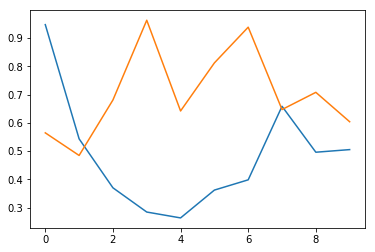

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

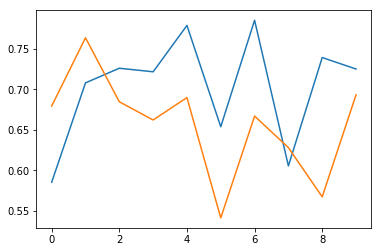

In [15]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

In [16]:
class Attention(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[2], 1),
                                      initializer='glorot_uniform',
                                      trainable=True)
        super(Attention, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        values = K.dot(x, self.kernel)
#         values = values + self.bias #K.sum(values, self.bias)
        weights = K.softmax(values)
        weighted_states = x*weights
        state = K.sum(weighted_states, axis=1)
        return state

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)


In [18]:
class DeepAttention(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(DeepAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[2], 1),
                                      initializer='glorot_uniform',
                                      trainable=True)
        self.mlp_layers = {}
        for i in range(self.num_of_layers):
            pass
            
        super(DeepAttention, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
#         x = K.permute_dimensions(x, pattern=(0,2,1))
        values = K.dot(x, self.kernel)
        print(values.shape)
        weights = K.softmax(values)
        print(weights.shape)
        weighted_states = x*weights
        print(weighted_states.shape)
        state = K.sum(weighted_states, axis=1)
        print(state.shape)
        return state

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [19]:
def attention_model(unique_tokens, embedding_size, rnn_size, max_len):
    model = Sequential()
    model.add(Embedding(unique_tokens, embedding_size, input_length=max_len))
    model.add(LSTM(rnn_size, return_sequences=True))
#     model.add(Concatenate(axis=1))
    print(model.output_shape)
    model.add(Attention(output_dim=rnn_size))
    model.add(Dense(rnn_size, activation='relu'))
    model.add(Dense(1, activation=None))
    return model

In [20]:
att_model = attention_model(unique_tokens=vocab_size, embedding_size=EMBEDDING_SIZE, rnn_size=32, max_len=MAX_LEN)

(None, 100, 32)


In [21]:
att_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 32)           1696256   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 32)           8320      
_________________________________________________________________
attention_1 (Attention)      (None, 32)                32        
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,705,697
Trainable params: 1,705,697
Non-trainable params: 0
_________________________________________________________________


In [22]:
optimizer = optimizers.Adam(0.0001)

att_model.compile(optimizer, 'binary_crossentropy', metrics=['acc'])

In [23]:
history = att_model.fit(epochs=10, x=train_X, y=train_y, validation_data=(test_X, test_y), batch_size=256, )

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 29s - loss: 0.7818 - acc: 0.5362 - val_loss: 0.6748 - val_acc: 0.5792
Epoch 2/10
25000/25000 [==============================] - 30s - loss: 0.6322 - acc: 0.6547 - val_loss: 0.6174 - val_acc: 0.6692
Epoch 3/10
25000/25000 [==============================] - 30s - loss: 0.5412 - acc: 0.7457 - val_loss: 0.5382 - val_acc: 0.7439
Epoch 4/10
25000/25000 [==============================] - 30s - loss: 0.4397 - acc: 0.8087 - val_loss: 0.4943 - val_acc: 0.7850
Epoch 5/10
25000/25000 [==============================] - 32s - loss: 0.3517 - acc: 0.8547 - val_loss: 0.4991 - val_acc: 0.8072
Epoch 6/10
25000/25000 [==============================] - 30s - loss: 0.2934 - acc: 0.8708 - val_loss: 0.5320 - val_acc: 0.8035
Epoch 7/10
25000/25000 [==============================] - 28s - loss: 0.2481 - acc: 0.8632 - val_loss: 0.6008 - val_acc: 0.7872
Epoch 8/10
25000/25000 [==============================

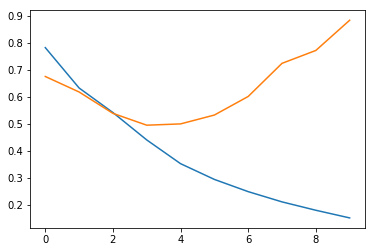

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

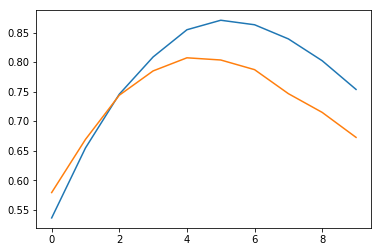

In [25]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])